# Отчет о запусках
---

## Прогон коллекций данных

Подгрузим метаданные.

In [1]:
import pandas as pd

df_meta = pd.read_csv('./data/meta_information.csv', index_col=0)
print('Number of datasets:', df_meta.shape[0])
df_meta.head(2)

Number of datasets: 31


,montage,pilote_id,last_train_idx,len(train),len(test)
0,2023-05-15_16-16-08.palm,1,23337,23337,5810
1,2023-05-15_17-12-24.palm,1,23336,23336,5803


Воспользуемся функцией `get_runs_report` из самописного модуля `useful_features`, чтобы рассчитать: 
- значения корреляции между таргетом и данными `Corr`, после исправления сдвига;
- значения корреляции между таргетом и данными в начале `corr_a` и в конце `corr_b` данных, рассчитанные при исправлении сдвига;
- значения F-меры для тестовых выборок: срдневзвешенной `f1_test` и отдельно по каждому жесту.

Расчет метрики F1 производится на предсказаниях модели, основанной на алгоритме SVC из библиотеки sklearn.

In [2]:
from useful_features import get_runs_report

runs_report_df = get_runs_report(df_meta)
runs_report_df.style.background_gradient(
    cmap='coolwarm',
    vmin=0, vmax=1,
    subset=list(runs_report_df.columns)[2:]
)

,pilote_id,file,Corr,corr_a,corr_b,f1_test,Neutral,Open,Pistol,Thumb,OK,Grab
0,1,2023-05-15_16-16-08,0.274356,0.412871,0.256877,0.764155,0.877851,0.847645,0.438596,0.000000,0.750685,0.762590
1,1,2023-05-15_17-12-24,0.020546,0.191707,0.023858,0.626233,0.801868,0.794233,0.221198,0.000000,0.354497,0.179431
2,1,2023-06-05_16-12-38,0.341675,0.448190,0.339225,0.595119,0.752891,0.757825,0.250587,0.000000,0.487619,0.383442
3,1,2023-06-05_17-53-01,0.353172,0.264307,0.413203,0.692151,0.812236,0.718287,0.574202,0.173494,0.596315,0.571429
4,1,2023-06-20_14-43-11,0.083280,0.179436,0.182742,0.604023,0.772545,0.658979,0.318008,0.000000,0.443203,0.422764
5,1,2023-06-20_13-30-15,0.274443,0.235754,0.382149,0.692694,0.806619,0.777126,0.280412,0.223278,0.708934,0.702163
6,1,2023-06-20_12-34-17,0.361622,0.414341,0.356253,0.735008,0.838365,0.805049,0.666667,0.005435,0.702128,0.770149
7,2,2023-09-30_08-06-44,0.400822,0.443222,0.358299,0.843979,0.894982,0.802083,0.834931,0.737276,0.688112,0.800793
8,2,2023-09-29_11-03-50,0.346494,0.384182,0.456843,0.904603,0.923192,0.909518,0.879195,0.923747,0.809976,0.870504
9,2,2023-09-29_09-20-47,0.271879,0.363008,0.308670,0.896487,0.918410,0.863081,0.880000,0.917595,0.882029,0.787013


Взглянем на корреляцию средневзвешенных F-мер со значениями корреляции таргетов и данных.

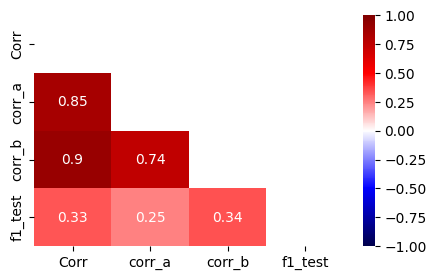

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Получаем матрицу корреляций
corr_matrix = runs_report_df[list(runs_report_df.columns[2:6])].corr()
# Выводим тепловую карту
matrix = np.triu(corr_matrix)
fig, axes = plt.subplots(figsize=(5, 3))
sns.heatmap(
    corr_matrix, vmin=-1, vmax=1, cmap='seismic',
    annot=True, mask=matrix, ax=axes
);

Как видим, корреляция имеется, но все же слабая.

Посмотрим также на график рассеяния F-мер в зависимости от значений общей корреляции данных со своими таргетами.

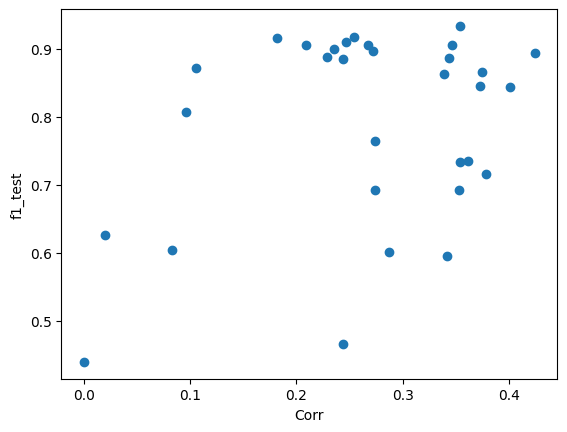

In [11]:
plt.scatter(runs_report_df['Corr'], runs_report_df['f1_test'])
plt.xlabel('Corr')
plt.ylabel('f1_test')
plt.show()

Похоже, мы можем визуально определить две плотные группы точек в верху и в правом верхнем углу. Также есть более разреженная группа в середине справа.

Можно утверждать, что при Corr < 0.1 гарантируется значение F1 < 0.65. У нас три датасете в этой группе.

Однако также три похожих датасета в группе с F1 < 0.65 при Corr > 0.2. Но доля датасетов с F1 > 0.65 в этой группе, разумеется, намного выше (допустим, мы отнесли два с F1 > 0.8 при Corr < 0.15 к первой группе). Тогда эти три датасета из второй группы можно условно отнести к категории в целом аномальных.

Выберем группу датасетов из таблицы с F1 < 0.65.

In [3]:
runs_report_df.query("f1_test < .65")

,pilote_id,file,Corr,corr_a,corr_b,f1_test,Neutral,Open,Pistol,Thumb,OK,Grab
1,1,2023-05-15_17-12-24,0.020546,0.191707,0.023858,0.626233,0.801868,0.794233,0.221198,0.000000,0.354497,0.179431
2,1,2023-06-05_16-12-38,0.341675,0.448190,0.339225,0.595119,0.752891,0.757825,0.250587,0.000000,0.487619,0.383442
4,1,2023-06-20_14-43-11,0.083280,0.179436,0.182742,0.604023,0.772545,0.658979,0.318008,0.000000,0.443203,0.422764
19,3,2023-05-07_16-54-27,0.287033,0.226872,0.270529,0.601466,0.679142,0.332806,0.636103,0.274223,0.442308,0.740659
23,2,2023-10-25_11-08-46,0.000339,0.080357,0.078398,0.439877,0.743256,0.000000,0.000000,0.000000,0.000000,0.000000
29,2,2023-10-18_08-05-29,0.243430,0.344915,0.232822,0.465606,0.385127,0.656023,0.800989,0.380463,0.234731,0.811275


Возможно, нам стоит избавиться от этих данных как некачественных.

---
## Исследование гомогенности выборок

Цель — проверить однородность данных в трейн и тест выборках во всех сетах.

In [6]:
from useful_features import get_data_homogeneity_report

data_homogeneity_report = get_data_homogeneity_report(df_meta)
data_homogeneity_report = pd.concat(
    [data_homogeneity_report, runs_report_df['f1_test']],
    axis=1
)

data_homogeneity_report.style.background_gradient(
    cmap='coolwarm',
    vmin=0.4, vmax=1,
    subset=list(data_homogeneity_report.columns)[2:]
)

,pilote_id,file,f1 train class (train),f1 test class (train),f1 train class (test),f1 test class (test),f1_test
0,1,2023-05-15_16-16-08,0.904536,0.524005,0.903886,0.531250,0.764155
1,1,2023-05-15_17-12-24,0.942819,0.749104,0.942881,0.754768,0.626233
2,1,2023-06-05_16-12-38,0.967793,0.864739,0.971216,0.876111,0.595119
3,1,2023-06-05_17-53-01,0.978468,0.912436,0.975424,0.903441,0.692151
4,1,2023-06-20_14-43-11,0.957577,0.821579,0.962798,0.846682,0.604023
5,1,2023-06-20_13-30-15,0.928417,0.688127,0.932897,0.695167,0.692694
6,1,2023-06-20_12-34-17,0.947771,0.776324,0.948107,0.788813,0.735008
7,2,2023-09-30_08-06-44,0.875542,0.874678,0.866191,0.866071,0.843979
8,2,2023-09-29_11-03-50,0.804119,0.805383,0.797651,0.802469,0.904603
9,2,2023-09-29_09-20-47,0.924366,0.922416,0.919786,0.919499,0.896487


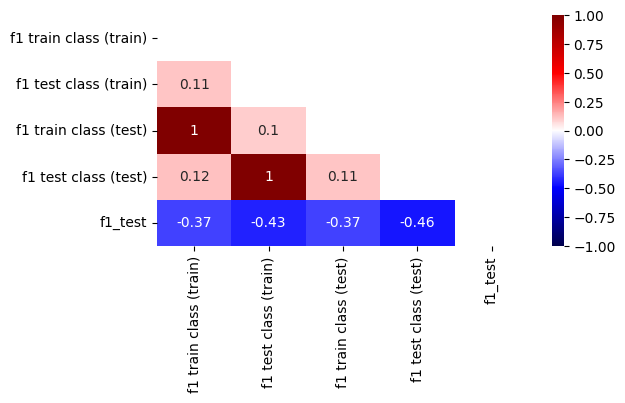

In [9]:
corr_matrix = data_homogeneity_report[
    list(data_homogeneity_report.columns[2:])
].corr()
matrix = np.triu(corr_matrix)
fig, axes = plt.subplots(figsize=(6, 3))
sns.heatmap(
    corr_matrix, vmin=-1, vmax=1, cmap='seismic',
    annot=True, mask=matrix, ax=axes
);

Полученный результат свидетельствует о наличии умеренной отрицательной корреляции между метриками предсказаний принадлежности строки данных к выборке (тестовой или треннировочной) и значениями метрик предсказания жестов.

Т.е. мы лишь с некоторой оговоркой можем утверждать, что чем хуже удалось предсказать принадлежность строки данных к выборке (тестовой или треннировочной), тем выше точность предсказания жестов. Различие в данных из тестовой и треннировочной действительно имеет место (см. кор. между метриками на трейн и тесте), но это, вероятно, не единственная причина плохих предсказаний жестов.

Как нас и предупреждали, вообще данные от сета к сету могут сильно отличаться из-за разницы в креплении манжеты с ОМГ-датчиками, а также из-за индивидуальных особенностей пилотов, качество выполнения команд также может иметь влияние на распознавание жестов моделью.